### Generate weights from NN training

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import scipy
from torchvision import transforms
import pickle

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
transform = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(21),
            torchvision.transforms.ToTensor(),
            # Apply with Lambda your custom transformation
#             torchvision.transforms.Lambda(lambda x:x/255.0),
        ])

In [ ]:
mnist_dev = torchvision.datasets.MNIST("./data", train=True, download=True, transform = transform)
mnist_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform = transform)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/TUM/Seminar
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/TUM/Seminar
edmd_graphs.ipynb  edmd_neural_networks.ipynb  out/


In [ ]:
n_train = 60000
n_test = len(mnist_dev) - n_train
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dev, [n_train, n_test])

In [ ]:
len(train_dataset)

60000

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 21, 21])

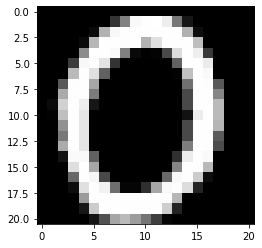

In [ ]:
plt.imshow(train_dataset[10][0][0,:,:], cmap="gray")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class Net(nn.Module):
    def __init__(self, activation=nn.ReLU(),
                 input_size=1*21*21, hidden_size=7, classes=10):
        
        super(Net, self).__init__()
        self.input_size = input_size

        # Here we initialize our activation and set up our two linear layers
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x

    def get_net_params(self):
        param_list = np.array([])
        for params in self.parameters():    
            param_list = np.concatenate((param_list, params.cpu().detach().numpy().flatten()))
        return param_list

In [ ]:
net = Net()
net.get_net_params().shape

(3174,)

In [ ]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
len(train_loader)

938

In [ ]:
def sample_nn_run(seed, optimizer_choice ="adam",sgd_mom=0.9):
    print("seed: ", seed)

    torch.manual_seed(seed)
    
    net = Net()
    # Always remember to move the network to the GPU/CPU depending on device
    net = net.to(device) 
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_choice == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0)
        
    if optimizer_choice == "SGD_mom":
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=sgd_mom)
    
    if optimizer_choice == "adam":
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        # adam with lr = 0.001
    
    
    print("Optimizer: ", optimizer )
    print("Shapes of the Parameter Matrix:")

    for parameter in net.parameters():
            print(parameter.shape)

    print("weight init shape: ", net.get_net_params().shape)
    print("weight init mean: ", net.get_net_params().mean())
    
    train_loss_history = [] # loss
    train_acc_history = [] # accuracy

    weights = [net.get_net_params()]
    test_weights = []
    train_loss = []
    
    w_update_i = 0
    
    for epoch in range(32):

        running_loss = 0.0
        correct = 0.0
        total = 0

        # Iterating through the minibatches of the data

        for i, data in enumerate(train_loader, 0):
            w_update_i +=1
            # data is a tuple of (inputs, labels)
            X, y = data

            X = X.to(device)
            y = y.to(device)

            # Reset the parameter gradients  for the current  minibatch iteration 
            optimizer.zero_grad()


            y_pred = net(X)             # Perform a forward pass on the network with inputs
            loss = criterion(y_pred, y) # calculate the loss with the network predictions and ground Truth
            loss.backward()             # Perform a backward pass to calculate the gradients
            optimizer.step()            # Optimize the network parameters with calculated gradients
            
            # save weights
            if (w_update_i >= 1000):
                test_weights.append(net.get_net_params())
            else:
                weights.append(net.get_net_params())
                        

            train_loss.append(loss.item())
                    
            # Accumulate the loss and calculate the accuracy of predictions
            running_loss += loss.item()
            _, preds = torch.max(y_pred, 1) #convert output probabilities of each class to a singular class prediction
            correct += preds.eq(y).sum().item()
            total += y.size(0)
        

            # Print statistics to console
            if i % 200 == 99: # print every 100 mini-batches
                running_loss /= 100
                correct /= total
                print("[Epoch %d, Iteration %5d] loss: %.3f acc: %.2f %%" % (epoch+1, i+1, running_loss, 100*correct))
                train_loss_history.append(running_loss)
                train_acc_history.append(correct)
                running_loss = 0.0
                correct = 0.0
                total = 0
        
#         train_loss.append(running_loss/len(train_loader))
    
    return weights, test_weights, train_loss

In [ ]:
w_adam, test_w_adam, train_loss_adam  = sample_nn_run(12, optimizer_choice = "adam")

seed:  12
Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916964274266274
[Epoch 1, Iteration   100] loss: 1.980 acc: 31.05 %
[Epoch 1, Iteration   300] loss: 2.129 acc: 70.42 %
[Epoch 1, Iteration   500] loss: 1.292 acc: 81.59 %
[Epoch 1, Iteration   700] loss: 1.016 acc: 85.81 %
[Epoch 1, Iteration   900] loss: 0.860 acc: 87.86 %
[Epoch 2, Iteration   100] loss: 0.391 acc: 89.22 %
[Epoch 2, Iteration   300] loss: 0.751 acc: 89.24 %
[Epoch 2, Iteration   500] loss: 0.777 acc: 89.07 %
[Epoch 2, Iteration   700] loss: 0.730 acc: 89.76 %
[Epoch 2, Iteration   900] loss: 0.703 acc: 90.20 %
[Epoch 3, Iteration   100] loss: 0.343 acc: 90.39 %
[Epoch 3,

In [ ]:
w_sgd_mom_05, test_w_sgd_mom_05, train_loss_sgd_mom_05  = sample_nn_run(12, optimizer_choice = "SGD_mom", sgd_mom = 0.5)

seed:  12
Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916964274266274
[Epoch 1, Iteration   100] loss: 2.305 acc: 17.72 %
[Epoch 1, Iteration   300] loss: 4.549 acc: 20.20 %
[Epoch 1, Iteration   500] loss: 4.461 acc: 22.06 %
[Epoch 1, Iteration   700] loss: 4.368 acc: 24.88 %
[Epoch 1, Iteration   900] loss: 4.272 acc: 28.77 %
[Epoch 2, Iteration   100] loss: 2.089 acc: 30.38 %
[Epoch 2, Iteration   300] loss: 4.082 acc: 30.59 %
[Epoch 2, Iteration   500] loss: 3.951 acc: 32.12 %
[Epoch 2, Iteration   700] loss: 3.826 acc: 32.56 %
[Epoch 2, Iteration   900] loss: 3.657 acc: 36.58 %
[Epoch 3, Iteration   100] loss: 1.752 acc: 41.30 %
[Epoch 3, Iteration   300] loss: 3.353 acc: 44.70 %


In [ ]:
w_sgd_mom_08, test_w_sgd_mom_08, train_loss_sgd_mom_08  = sample_nn_run(12, optimizer_choice = "SGD_mom", sgd_mom = 0.8)

seed:  12
Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.8
    nesterov: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916964274266274
[Epoch 1, Iteration   100] loss: 2.292 acc: 18.95 %
[Epoch 1, Iteration   300] loss: 4.422 acc: 23.61 %
[Epoch 1, Iteration   500] loss: 4.162 acc: 30.68 %
[Epoch 1, Iteration   700] loss: 3.861 acc: 33.22 %
[Epoch 1, Iteration   900] loss: 3.455 acc: 42.37 %
[Epoch 2, Iteration   100] loss: 1.531 acc: 54.20 %
[Epoch 2, Iteration   300] loss: 2.753 acc: 63.82 %
[Epoch 2, Iteration   500] loss: 2.416 acc: 69.43 %
[Epoch 2, Iteration   700] loss: 2.118 acc: 73.95 %
[Epoch 2, Iteration   900] loss: 1.900 acc: 75.73 %
[Epoch 3, Iteration   100] loss: 0.865 acc: 77.61 %
[Epoch 3, Iteration   300] loss: 1.619 acc: 78.32 %


In [ ]:
w_sgd_mom_09, test_w_sgd_mom_09, train_loss_sgd_mom_09  = sample_nn_run(12, optimizer_choice = "SGD_mom", sgd_mom = 0.9)

seed:  12
Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916964274266274
[Epoch 1, Iteration   100] loss: 2.274 acc: 19.36 %
[Epoch 1, Iteration   300] loss: 4.206 acc: 28.61 %
[Epoch 1, Iteration   500] loss: 3.563 acc: 40.43 %
[Epoch 1, Iteration   700] loss: 2.794 acc: 61.16 %
[Epoch 1, Iteration   900] loss: 2.149 acc: 72.53 %
[Epoch 2, Iteration   100] loss: 0.871 acc: 78.12 %
[Epoch 2, Iteration   300] loss: 1.543 acc: 79.05 %
[Epoch 2, Iteration   500] loss: 1.383 acc: 80.87 %
[Epoch 2, Iteration   700] loss: 1.238 acc: 83.07 %
[Epoch 2, Iteration   900] loss: 1.159 acc: 83.80 %
[Epoch 3, Iteration   100] loss: 0.547 acc: 84.81 %
[Epoch 3, Iteration   300] loss: 1.056 acc: 85.17 %


In [ ]:
w_sgd, test_w_sgd, train_loss_sgd  = sample_nn_run(12, optimizer_choice = "SGD")

seed:  12
Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916964274266274
[Epoch 1, Iteration   100] loss: 2.310 acc: 17.34 %
[Epoch 1, Iteration   300] loss: 4.590 acc: 18.98 %
[Epoch 1, Iteration   500] loss: 4.543 acc: 20.66 %
[Epoch 1, Iteration   700] loss: 4.504 acc: 20.73 %
[Epoch 1, Iteration   900] loss: 4.468 acc: 21.89 %
[Epoch 2, Iteration   100] loss: 2.212 acc: 23.19 %
[Epoch 2, Iteration   300] loss: 4.378 acc: 24.86 %
[Epoch 2, Iteration   500] loss: 4.317 acc: 27.91 %
[Epoch 2, Iteration   700] loss: 4.292 acc: 28.41 %
[Epoch 2, Iteration   900] loss: 4.237 acc: 29.12 %
[Epoch 3, Iteration   100] loss: 2.094 acc: 29.62 %
[Epoch 3, Iteration   300] loss: 4.136 acc: 30.89 %
[E

#### check if all trainings had the same initialisation

In [ ]:
assert (w_sgd[0] == w_adam[0]).all()
assert (w_adam[0] == w_sgd_mom_05[0]).all()
assert (w_sgd_mom_05[0] == w_sgd_mom_08[0]).all()
assert (w_sgd_mom_08[0] == w_sgd_mom_09[0]).all()

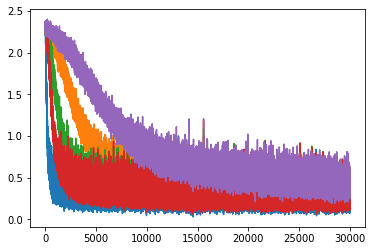

In [ ]:
plt.plot(train_loss_adam)
plt.plot(train_loss_sgd_mom_05)
plt.plot(train_loss_sgd_mom_08)
plt.plot(train_loss_sgd_mom_09)
plt.plot(train_loss_sgd)

In [ ]:
np.array(w_adam).shape, np.array(test_w_adam).shape

((1000, 3174), (29017, 3174))

In [ ]:
w_adam = np.array(w_adam)
test_w_adam = np.array(test_w_adam)

In [ ]:
w_sgd = np.array(w_sgd)
test_w_sgd = np.array(test_w_sgd)

In [ ]:
w_sgd_mom_05 = np.array(w_sgd_mom_05)
test_w_sgd_mom_05 = np.array(test_w_sgd_mom_05)

In [ ]:
w_sgd_mom_08 = np.array(w_sgd_mom_08)
test_w_sgd_mom_08 = np.array(test_w_sgd_mom_08)

In [ ]:
w_sgd_mom_09 = np.array(w_sgd_mom_09)
test_w_sgd_mom_09 = np.array(test_w_sgd_mom_09)

In [ ]:
np.save("./out/w_adam_nn.pkl", w_adam)
np.save("./out/test_w_adam_nn.pkl", test_w_adam)

In [ ]:
np.save("./out/w_sgd_nn.pkl", w_sgd)
np.save("./out/test_w_sgd_nn.pkl", test_w_sgd)

In [ ]:
np.save("./out/w_sgd_mom_nn_05.pkl", w_sgd_mom_05)
np.save("./out/test_w_sgd_mom_nn_05.pkl", test_w_sgd_mom_05)

In [ ]:
np.save("./out/w_sgd_mom_nn_08.pkl", w_sgd_mom_08)
np.save("./out/test_w_sgd_mom_nn_08.pkl", test_w_sgd_mom_08)

In [ ]:
np.save("./out/w_sgd_mom_nn_09.pkl", w_sgd_mom_09)
np.save("./out/test_w_sgd_mom_nn_09.pkl", test_w_sgd_mom_09)

### Use weights for approximating koopman operator

### apply EDMD to ADAM trained NN

In [ ]:
w = np.load("./out/w_adam_nn.pkl.npy")

In [ ]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462917,
        -0.05136227,  0.30388868],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02562917,
        -0.05036227,  0.30288869],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02628865,
        -0.04988426,  0.30216047],
       ...,
       [ 0.00134178, -0.00283511,  0.05546506, ...,  0.25231582,
        -0.36550218,  0.33523566],
       [ 0.00138147, -0.00275471,  0.05556942, ...,  0.25250667,
        -0.36571214,  0.3350547 ],
       [ 0.00141722, -0.00268228,  0.05565841, ...,  0.2526226 ,
        -0.36591136,  0.33490711]])

In [ ]:
w.shape


(1000, 3174)

#### define thin plate radial basis functions

In [ ]:
from scipy.spatial import distance
def rbf_thin_plate(centers, x):
    delta = 10**-3
    out = []
    for c in centers:
        out.append((distance.euclidean(c,x)**2) * np.log(distance.euclidean(c,x) + delta))
    
    return(np.array(out))

#### apply kmeans to get centers for radial basis fucntions

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=18)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 0.08523976114140772
Iteration 1, inertia 0.06526143856733906
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.08523976114140772
Iteration 1, inertia 0.06526143856733906
Converged at iteration 1: strict convergence.


array([[-9.44093335e-03, -2.01704533e-02,  5.54759304e-02, ...,
         2.04942301e-01, -1.74575642e-01,  3.11695059e-01],
       [-1.12740851e-02, -1.23141950e-03,  5.65410381e-02, ...,
         2.52500286e-01, -3.17858378e-01,  3.28549067e-01],
       [-2.73243844e-04, -2.49525663e-02, -4.93954925e-04, ...,
         9.08458009e-02, -7.15772808e-02,  2.76064456e-01],
       ...,
       [-2.08192673e-02, -7.66798318e-03,  6.09829519e-02, ...,
         2.40352884e-01, -2.73232594e-01,  3.19249302e-01],
       [-1.50589747e-02, -2.24775113e-02,  3.51114348e-02, ...,
         1.74339503e-01, -1.38548166e-01,  3.05914581e-01],
       [-1.50818843e-02, -2.29052585e-02,  3.34529318e-02, ...,
         1.73237234e-01, -1.37430996e-01,  3.05696756e-01]])

In [ ]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(1000, 3774)

In [ ]:
np.save("./out/w_t_combined_adam.pkl", w_t_combined)

In [ ]:
w_t_combined = np.load("./out/w_t_combined_adam.pkl.npy")
w_t_combined.shape

(1000, 3774)

In [ ]:
!pip install datafold
from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis, TSCIdentity, TSCApplyLambdas, TSCFeaturePreprocess
from datafold.pcfold import GaussianKernel, TSCDataFrame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(1000, 3774)

In [ ]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 1000
(n_samples, n_features): (1000, 3774)
time interval (0, 999)
Same time values: True


In [ ]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_adam = EDMD(dict_steps=dict_step, include_id_state=False, sort_koopman_triplets=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1169: UserWarning: There are more observables than snapshots. The current implementation favors more snapshots than obserables. This may result in a bad computational performance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=182), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [ ]:
edmd_adam

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [ ]:
import pickle
with open('./out/edmd_adam.pkl', 'wb') as outp:
    pickle.dump(edmd_adam, outp, pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('./out/edmd_adam.pkl', 'rb') as inp:
    edmd_adam = pickle.load(inp)

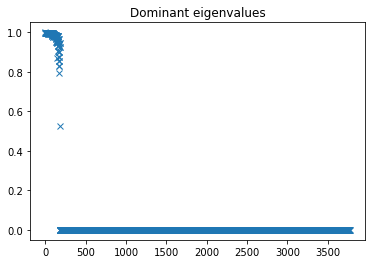

In [ ]:
plt.plot(np.abs(edmd_adam.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [ ]:
sum(np.abs(edmd_adam.koopman_eigenvalues) > 0.05)

182

### Apply edmd to sgd trainied NN

In [ ]:
w = np.load("./out/w_sgd_nn.pkl.npy")

In [ ]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462917,
        -0.05136227,  0.30388868],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02470678,
        -0.05131111,  0.30378413],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02470719,
        -0.05132359,  0.30377361],
       ...,
       [-0.00326051, -0.02544208, -0.00449977, ...,  0.04023848,
        -0.04711104,  0.26423621],
       [-0.00326051, -0.02544208, -0.00449977, ...,  0.04029252,
        -0.04714193,  0.26419175],
       [-0.00326051, -0.02544208, -0.00449992, ...,  0.04022689,
        -0.04712648,  0.26417667]])

In [ ]:
w.shape

(1000, 3174)

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 0.00010096989263609646
Iteration 1, inertia 6.197285168912658e-05
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.00010096989263609646
Iteration 1, inertia 6.197285168912658e-05
Converged at iteration 1: strict convergence.


array([[-0.00326094, -0.02544647, -0.00450721, ...,  0.03944255,
        -0.04743619,  0.26741365],
       [-0.00326697, -0.02544625, -0.00449525, ...,  0.02837653,
        -0.04942124,  0.29294278],
       [-0.00326375, -0.02544564, -0.00450178, ...,  0.03436438,
        -0.04806807,  0.27968618],
       ...,
       [-0.00326681, -0.02544566, -0.00449816, ...,  0.02961277,
        -0.04939905,  0.28945065],
       [-0.0032639 , -0.02544622, -0.0045048 , ...,  0.03203251,
        -0.0482736 ,  0.28377202],
       [-0.00326374, -0.02544598, -0.00450472, ...,  0.03245549,
        -0.04836662,  0.28334519]])

In [ ]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(1000, 3774)

In [ ]:
np.save("./out/w_t_combined_sgd.pkl", w_t_combined)

In [ ]:
w_t_combined = np.load("./out/w_t_combined_sgd.pkl.npy")
w_t_combined.shape

(1000, 3774)

In [ ]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(1000, 3774)

In [ ]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 1000
(n_samples, n_features): (1000, 3774)
time interval (0, 999)
Same time values: True


In [ ]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_sgd = EDMD(dict_steps=dict_step, include_id_state=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1169: UserWarning: There are more observables than snapshots. The current implementation favors more snapshots than obserables. This may result in a bad computational performance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=593), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [ ]:
edmd_sgd

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [ ]:
import pickle
with open('./out/edmd_sgd.pkl', 'wb') as outp:
    pickle.dump(edmd_sgd, outp, pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('./out/edmd_sgd.pkl', 'rb') as inp:
    edmd_sgd = pickle.load(inp)

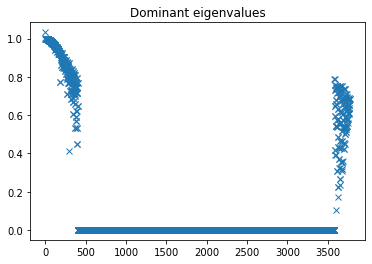

In [ ]:
plt.plot(np.abs(edmd_sgd.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [ ]:
sum(np.abs(edmd_sgd.koopman_eigenvalues) > 0.05)

593

### Apply EDMD to SGD with momentum weights

#### Mom 0.5

In [ ]:
w = np.load("./out/w_sgd_mom_nn_05.pkl.npy")

In [ ]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462917,
        -0.05136227,  0.30388868],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02470678,
        -0.05131111,  0.30378413],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.024746  ,
        -0.05129801,  0.30372134],
       ...,
       [-0.00325144, -0.02541691, -0.00447384, ...,  0.06191796,
        -0.0417525 ,  0.22644496],
       [-0.00325143, -0.02541687, -0.00447383, ...,  0.06197811,
        -0.04175567,  0.22635657],
       [-0.00325143, -0.02541685, -0.00447398, ...,  0.06195034,
        -0.04173821,  0.22630377]])

In [ ]:
w.shape

(1000, 3174)

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 0.00027037780672324054
Iteration 1, inertia 0.0001859395363075665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.00027037780672324054
Iteration 1, inertia 0.0001859395363075665
Converged at iteration 1: strict convergence.


array([[-0.00325293, -0.02542354, -0.00448956, ...,  0.0593981 ,
        -0.04276667,  0.23225126],
       [-0.00326545, -0.02544071, -0.00448269, ...,  0.03346431,
        -0.04786838,  0.28030092],
       [-0.00325887, -0.02542584, -0.00448782, ...,  0.04560074,
        -0.04510813,  0.25657684],
       ...,
       [-0.00326601, -0.02544566, -0.0044916 , ...,  0.03238211,
        -0.04803405,  0.28457716],
       [-0.00325372, -0.02541838, -0.00447792, ...,  0.05768312,
        -0.04347732,  0.23629159],
       [-0.00325357, -0.02541787, -0.00447971, ...,  0.05806288,
        -0.04345362,  0.23572476]])

In [ ]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(1000, 3774)

In [ ]:
np.save("./out/w_t_combined_sgd_mom_05.pkl", w_t_combined)

In [ ]:
w_t_combined = np.load("./out/w_t_combined_sgd_mom_05.pkl.npy")
w_t_combined.shape

(1000, 3774)

In [ ]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(1000, 3774)

In [ ]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 1000
(n_samples, n_features): (1000, 3774)
time interval (0, 999)
Same time values: True


In [ ]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_sgd_mom_05 = EDMD(dict_steps=dict_step, include_id_state=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1169: UserWarning: There are more observables than snapshots. The current implementation favors more snapshots than obserables. This may result in a bad computational performance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=529), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [ ]:
edmd_sgd_mom_05

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [ ]:
import pickle
with open('./out/edmd_sgd_mom_05.pkl', 'wb') as outp:
    pickle.dump(edmd_sgd_mom_05, outp, pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('./out/edmd_sgd_mom_05.pkl', 'rb') as inp:
    edmd_sgd_mom_05 = pickle.load(inp)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


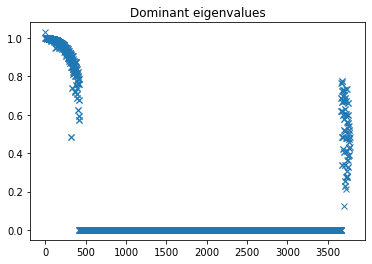

In [ ]:
plt.plot(np.abs(edmd_sgd_mom_05.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [ ]:
sum(np.abs(edmd_sgd_mom_05.koopman_eigenvalues) > 0.05)

529

#### Mom 0.8

In [ ]:
w = np.load("./out/w_sgd_mom_nn_08.pkl.npy")

In [ ]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462917,
        -0.05136227,  0.30388868],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02470678,
        -0.05131111,  0.30378413],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02476929,
        -0.05128266,  0.30368996],
       ...,
       [-0.00321885, -0.02537124, -0.00439638, ...,  0.15275468,
        -0.06314471,  0.21205558],
       [-0.0032188 , -0.02537095, -0.00439616, ...,  0.15291004,
        -0.06327224,  0.21213308],
       [-0.00321876, -0.02537071, -0.00439551, ...,  0.15299197,
        -0.06337737,  0.21223491]])

In [ ]:
w.shape

(1000, 3174)

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 0.0016575281310299422
Iteration 1, inertia 0.0012767019846838803
Iteration 2, inertia 0.001273330339454698
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 0.0016575281310299422
Iteration 1, inertia 0.0012767019846838803
Iteration 2, inertia 0.001273330339454698
Converged at iteration 2: strict convergence.


array([[-0.00322716, -0.02539619, -0.00447398, ...,  0.14248624,
        -0.05378844,  0.20486531],
       [-0.00326641, -0.02543068, -0.00449692, ...,  0.05253762,
        -0.04264835,  0.24096201],
       [-0.00325141, -0.02540014, -0.00451151, ...,  0.09474239,
        -0.03226646,  0.1948543 ],
       ...,
       [-0.00325149, -0.02539894, -0.004507  , ...,  0.09037218,
        -0.03305033,  0.19671032],
       [-0.00324066, -0.02536292, -0.00445455, ...,  0.12190988,
        -0.0385679 ,  0.1966453 ],
       [-0.00324058, -0.02535796, -0.00444188, ...,  0.12707405,
        -0.04202028,  0.19921158]])

In [ ]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(1000, 3774)

In [ ]:
np.save("./out/w_t_combined_sgd_mom_08.pkl", w_t_combined)

In [ ]:
w_t_combined = np.load("./out/w_t_combined_sgd_mom_08.pkl.npy")
w_t_combined.shape

(1000, 3774)

In [ ]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(1000, 3774)

In [ ]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 1000
(n_samples, n_features): (1000, 3774)
time interval (0, 999)
Same time values: True


In [ ]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_sgd_mom_08 = EDMD(dict_steps=dict_step, include_id_state=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1169: UserWarning: There are more observables than snapshots. The current implementation favors more snapshots than obserables. This may result in a bad computational performance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=427), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [ ]:
edmd_sgd_mom_08

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [ ]:
import pickle
with open('./out/edmd_sgd_mom_08.pkl', 'wb') as outp:
    pickle.dump(edmd_sgd_mom_08, outp, pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('./out/edmd_sgd_mom_08.pkl', 'rb') as inp:
    edmd_sgd_mom_08 = pickle.load(inp)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


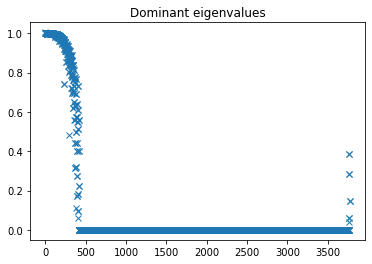

In [ ]:
plt.plot(np.abs(edmd_sgd_mom_08.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [ ]:
sum(np.abs(edmd_sgd_mom_08.koopman_eigenvalues) > 0.05)

426

#### Mom 0.9

In [ ]:
w = np.load("./out/w_sgd_mom_nn_09.pkl.npy")

In [ ]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462917,
        -0.05136227,  0.30388868],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02470678,
        -0.05131111,  0.30378413],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02477705,
        -0.05127754,  0.30367953],
       ...,
       [-0.00308363, -0.02494684, -0.00330313, ...,  0.22851153,
        -0.12763649,  0.24968919],
       [-0.00308341, -0.0249458 , -0.00329963, ...,  0.22861886,
        -0.12774314,  0.24970017],
       [-0.00308321, -0.02494487, -0.00329689, ...,  0.22868338,
        -0.1278304 ,  0.24971782]])

In [ ]:
w.shape

(1000, 3174)

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 0.0057976650744064615
Iteration 1, inertia 0.0043938296503178665
Iteration 2, inertia 0.0043783313714512535
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 0.0057976650744064615
Iteration 1, inertia 0.0043938296503178665
Iteration 2, inertia 0.0043783313714512535
Converged at iteration 2: strict convergence.


array([[-0.0031179 , -0.02504632, -0.00366455, ...,  0.22248554,
        -0.11901774,  0.24461748],
       [-0.0032635 , -0.02543513, -0.00443349, ...,  0.0840817 ,
        -0.02988173,  0.19040865],
       [-0.00325567, -0.02531766, -0.00432778, ...,  0.17974314,
        -0.06887129,  0.20737661],
       ...,
       [-0.00326338, -0.02543479, -0.00444719, ...,  0.08531627,
        -0.02988857,  0.18927246],
       [-0.00327255, -0.02539268, -0.00446976, ...,  0.12906565,
        -0.03088484,  0.17825367],
       [-0.00329071, -0.02546409, -0.00450256, ...,  0.09777693,
        -0.02855275,  0.17692459]])

In [ ]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_transformed.shape

(1000, 600)

In [ ]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(1000, 3774)

In [ ]:
np.save("./out/w_t_combined_sgd_mom_09.pkl", w_t_combined)

In [ ]:
w_t_combined = np.load("./out/w_t_combined_sgd_mom_09.pkl.npy")
w_t_combined.shape

(1000, 3774)

In [ ]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(1000, 3774)

In [ ]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 1000
(n_samples, n_features): (1000, 3774)
time interval (0, 999)
Same time values: True


In [ ]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_sgd_mom_09 = EDMD(dict_steps=dict_step, include_id_state=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1169: UserWarning: There are more observables than snapshots. The current implementation favors more snapshots than obserables. This may result in a bad computational performance.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=182), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [ ]:
edmd_sgd_mom_09

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [ ]:
import pickle
with open('./out/edmd_sgd_mom_09.pkl', 'wb') as outp:
    pickle.dump(edmd_sgd_mom_09, outp, pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('./out/edmd_sgd_mom_09.pkl', 'rb') as inp:
    edmd_sgd_mom_09 = pickle.load(inp)

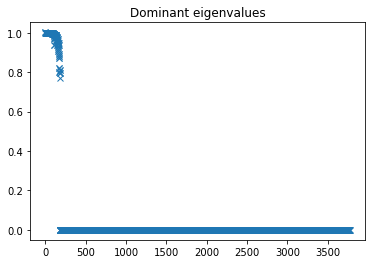

In [ ]:
plt.plot(np.abs(edmd_sgd_mom_09.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [ ]:
sum(np.abs(edmd_sgd_mom_09.koopman_eigenvalues) > 0.05)

182